In [1]:
import os
os.chdir("../")

In [2]:
import torch
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

from src.preprocess.normalizer import Normalizer
from src.evaluate.evaluate import convert_target_to_binary
from src import evaluate
from src.utils import load_pickle
from constants import BASE_PATH, FILLER_LABELING_THRESHOLD

In [3]:
FEATURES_PATH = os.path.join(BASE_PATH, "data/processed_data/features/")
TARGETS_PATH = os.path.join(BASE_PATH, "data/processed_data/targets/")

# Prepare the data

In [4]:
%%time
x = torch.tensor([])
y = torch.tensor([])

for speaker_filename in os.listdir(FEATURES_PATH):
    current_x = load_pickle(f"{FEATURES_PATH}/{speaker_filename}")
    current_y = load_pickle(f"{TARGETS_PATH}/{speaker_filename}")

    x = torch.concat((x, current_x), dim=1)
    y = torch.concat((y, current_y), dim=0)

CPU times: user 294 ms, sys: 301 ms, total: 594 ms
Wall time: 594 ms


In [5]:
x_train, x_valid, y_train, y_valid = train_test_split(
    x.transpose(0, 1),
    convert_target_to_binary(y, threshold=FILLER_LABELING_THRESHOLD), 
    test_size=0.33,
    shuffle=False,
)

In [6]:
normalizer = Normalizer()

In [7]:
x_train = normalizer.fit_transform(x_train)
x_valid = normalizer.transform(x_valid)

In [8]:
x_train.mean(), x_train.std()

(tensor(-6.4711e-09), tensor(1.))

In [9]:
x_valid.mean(), x_valid.std()

(tensor(-0.0358), tensor(1.1684))

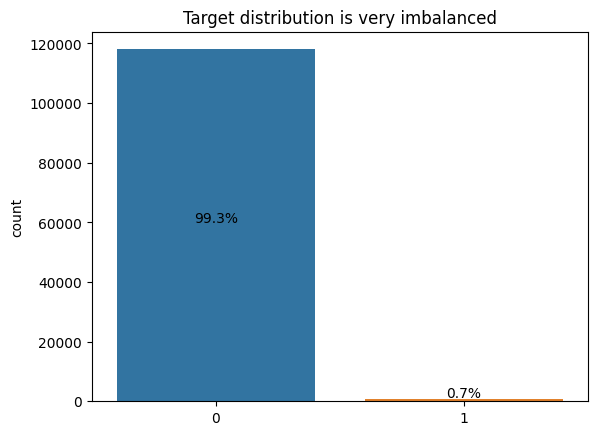

In [10]:
fig,ax = plt.subplots()
sns.countplot(x=y_valid.numpy().astype(int), ax=ax)

# show the count in %
for p in ax.patches:
    h_, w_, x_ = p.get_height(), p.get_width(), p.get_x()
    xy_ = (x_ + w_ / 2., h_ / 2)
    pct = 100 * h_ / y_valid.shape[0]
    text = f'{pct:0.1f}%'
    ax.annotate(text=text, xy=xy_, ha='center', va='bottom')
    
plt.title("Target distribution is very imbalanced")
plt.show()

---

### Train using created class

In [11]:
from src.model.multi_layer_perceptron import MultiLayerPerceptron

In [12]:
mlp = MultiLayerPerceptron(
    n_features=x_train.size(1), 
    n_hidden=512, 
    n_out=1,
    main_metric="avg_precision_score",
    batch_size=256,
    dropout_proba=0.2,
    learning_rate=3e-4,
    weight_decay=1e-4,
)

In [13]:
mlp.fit(x_train, y_train, x_valid, y_valid, n_epochs=20)

epoch: 1 | train loss: 0.012 | valid loss: 0.012 | train avg_precision_score: 0.13 | valid avg_precision_score: 0.082
epoch: 2 | train loss: 0.011 | valid loss: 0.011 | train avg_precision_score: 0.16 | valid avg_precision_score: 0.087
epoch: 3 | train loss: 0.011 | valid loss: 0.011 | train avg_precision_score: 0.17 | valid avg_precision_score: 0.088
epoch: 4 | train loss: 0.01 | valid loss: 0.011 | train avg_precision_score: 0.18 | valid avg_precision_score: 0.089
epoch: 5 | train loss: 0.01 | valid loss: 0.011 | train avg_precision_score: 0.184 | valid avg_precision_score: 0.09
epoch: 6 | train loss: 0.01 | valid loss: 0.011 | train avg_precision_score: 0.189 | valid avg_precision_score: 0.091
epoch: 7 | train loss: 0.01 | valid loss: 0.011 | train avg_precision_score: 0.192 | valid avg_precision_score: 0.092
epoch: 8 | train loss: 0.01 | valid loss: 0.011 | train avg_precision_score: 0.197 | valid avg_precision_score: 0.094
epoch: 9 | train loss: 0.01 | valid loss: 0.011 | train av

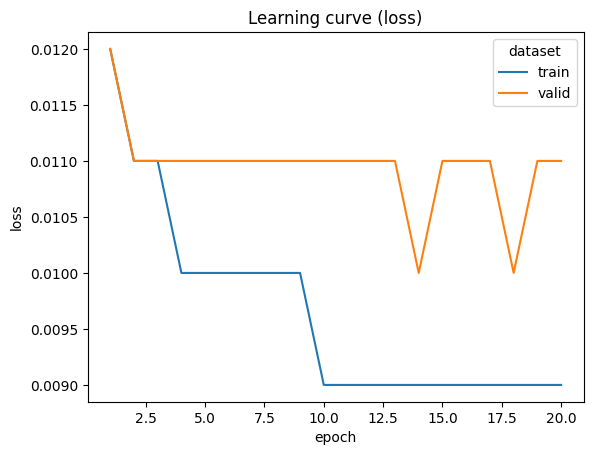

In [14]:
sns.lineplot(data=mlp.history, x="epoch", y="loss", hue="dataset")
plt.title("Learning curve (loss)");

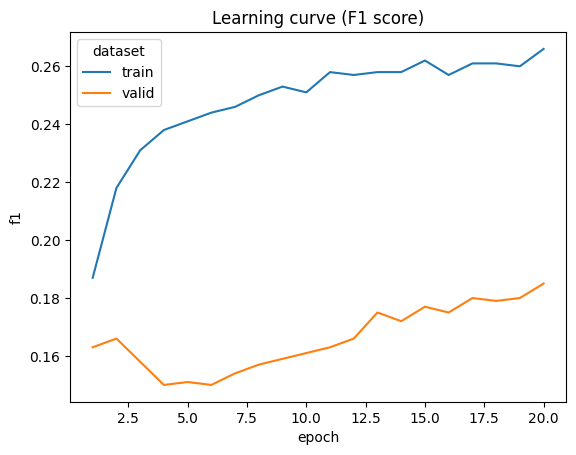

In [15]:
sns.lineplot(data=mlp.history, x="epoch", y="f1", hue="dataset")
plt.title("Learning curve (F1 score)");

f1: 0.185, precision: 0.134, recall: 0.3, avg_precision_score: 0.107


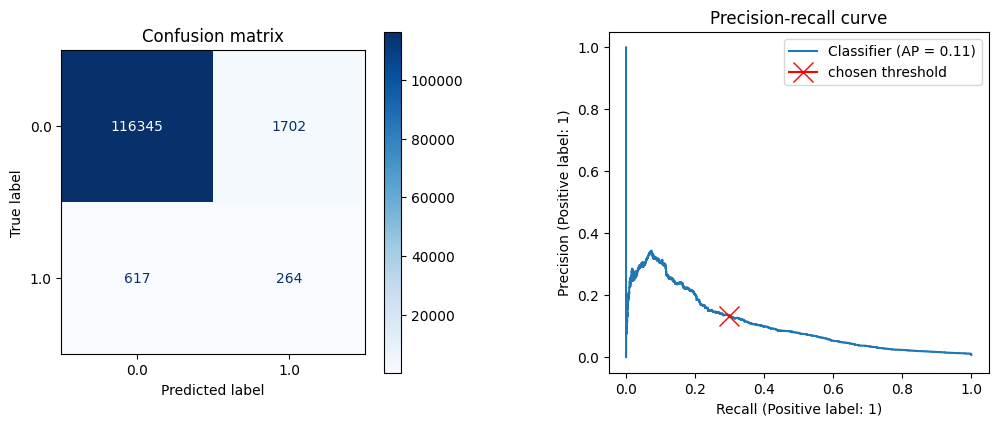

In [16]:
mlp.evaluate(x_valid, y_valid)

---